Title: Homework 1\
Author: Roy Wang\
Date: January 29th, 2024


# 1. Derive the least squares solve


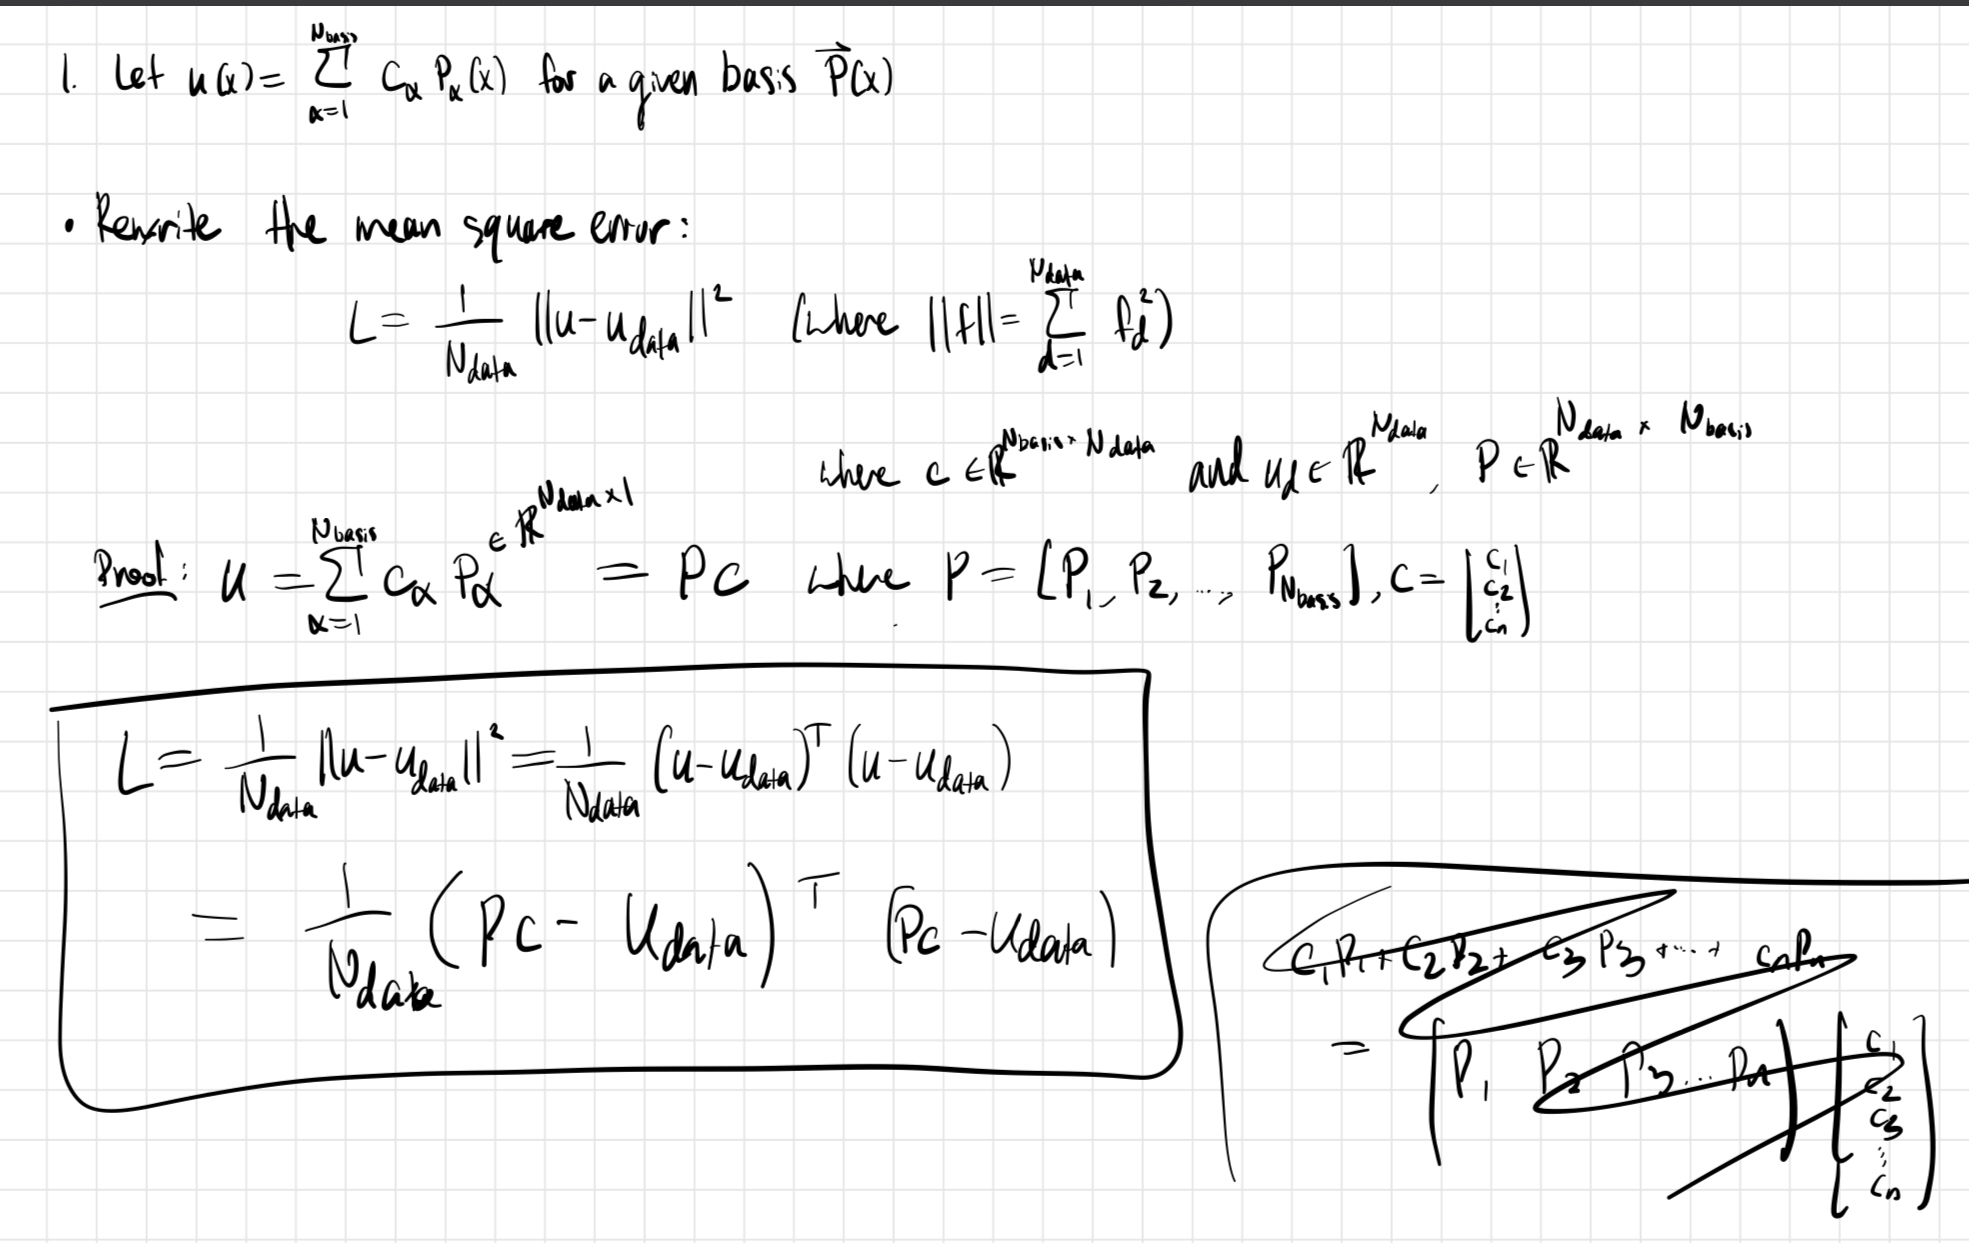

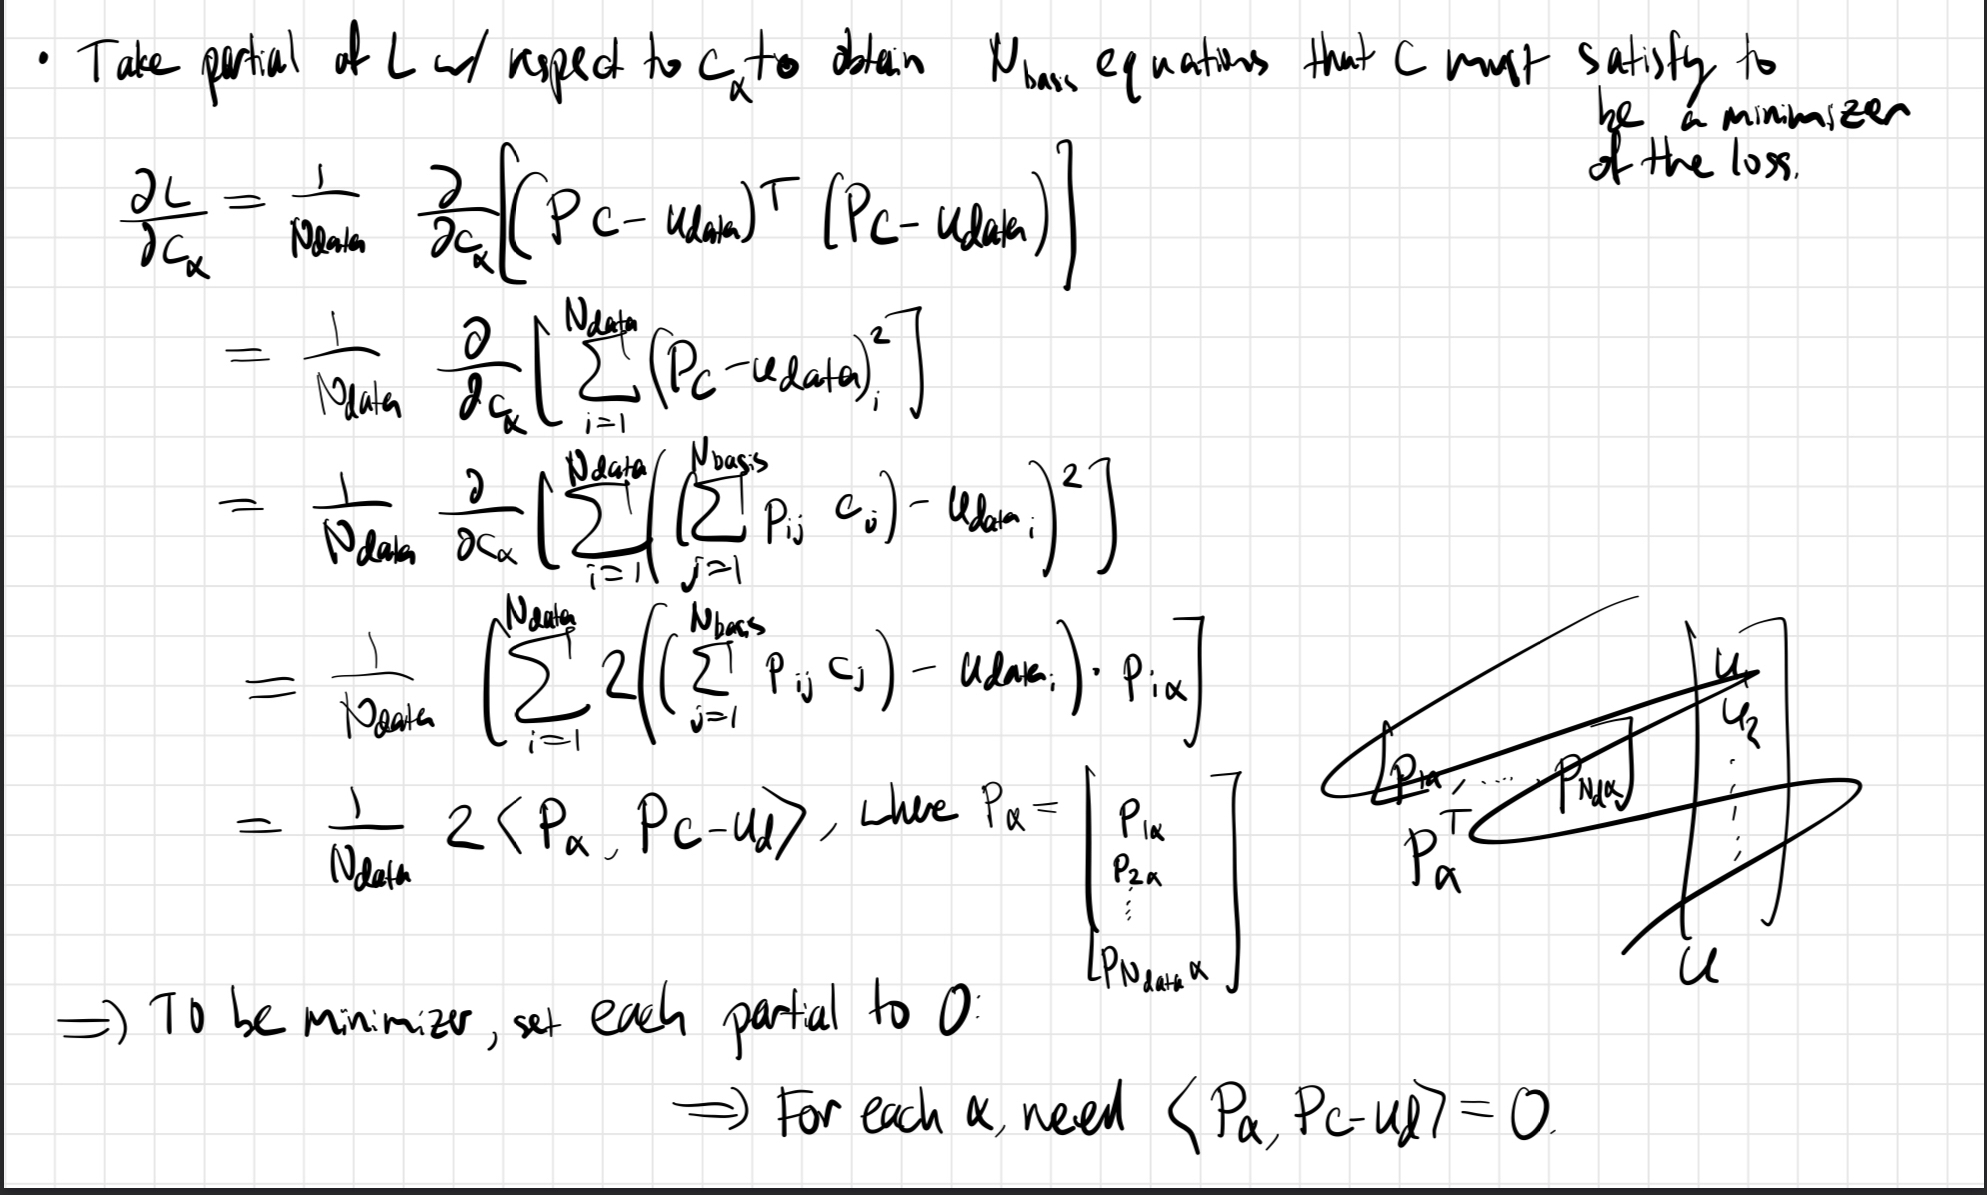

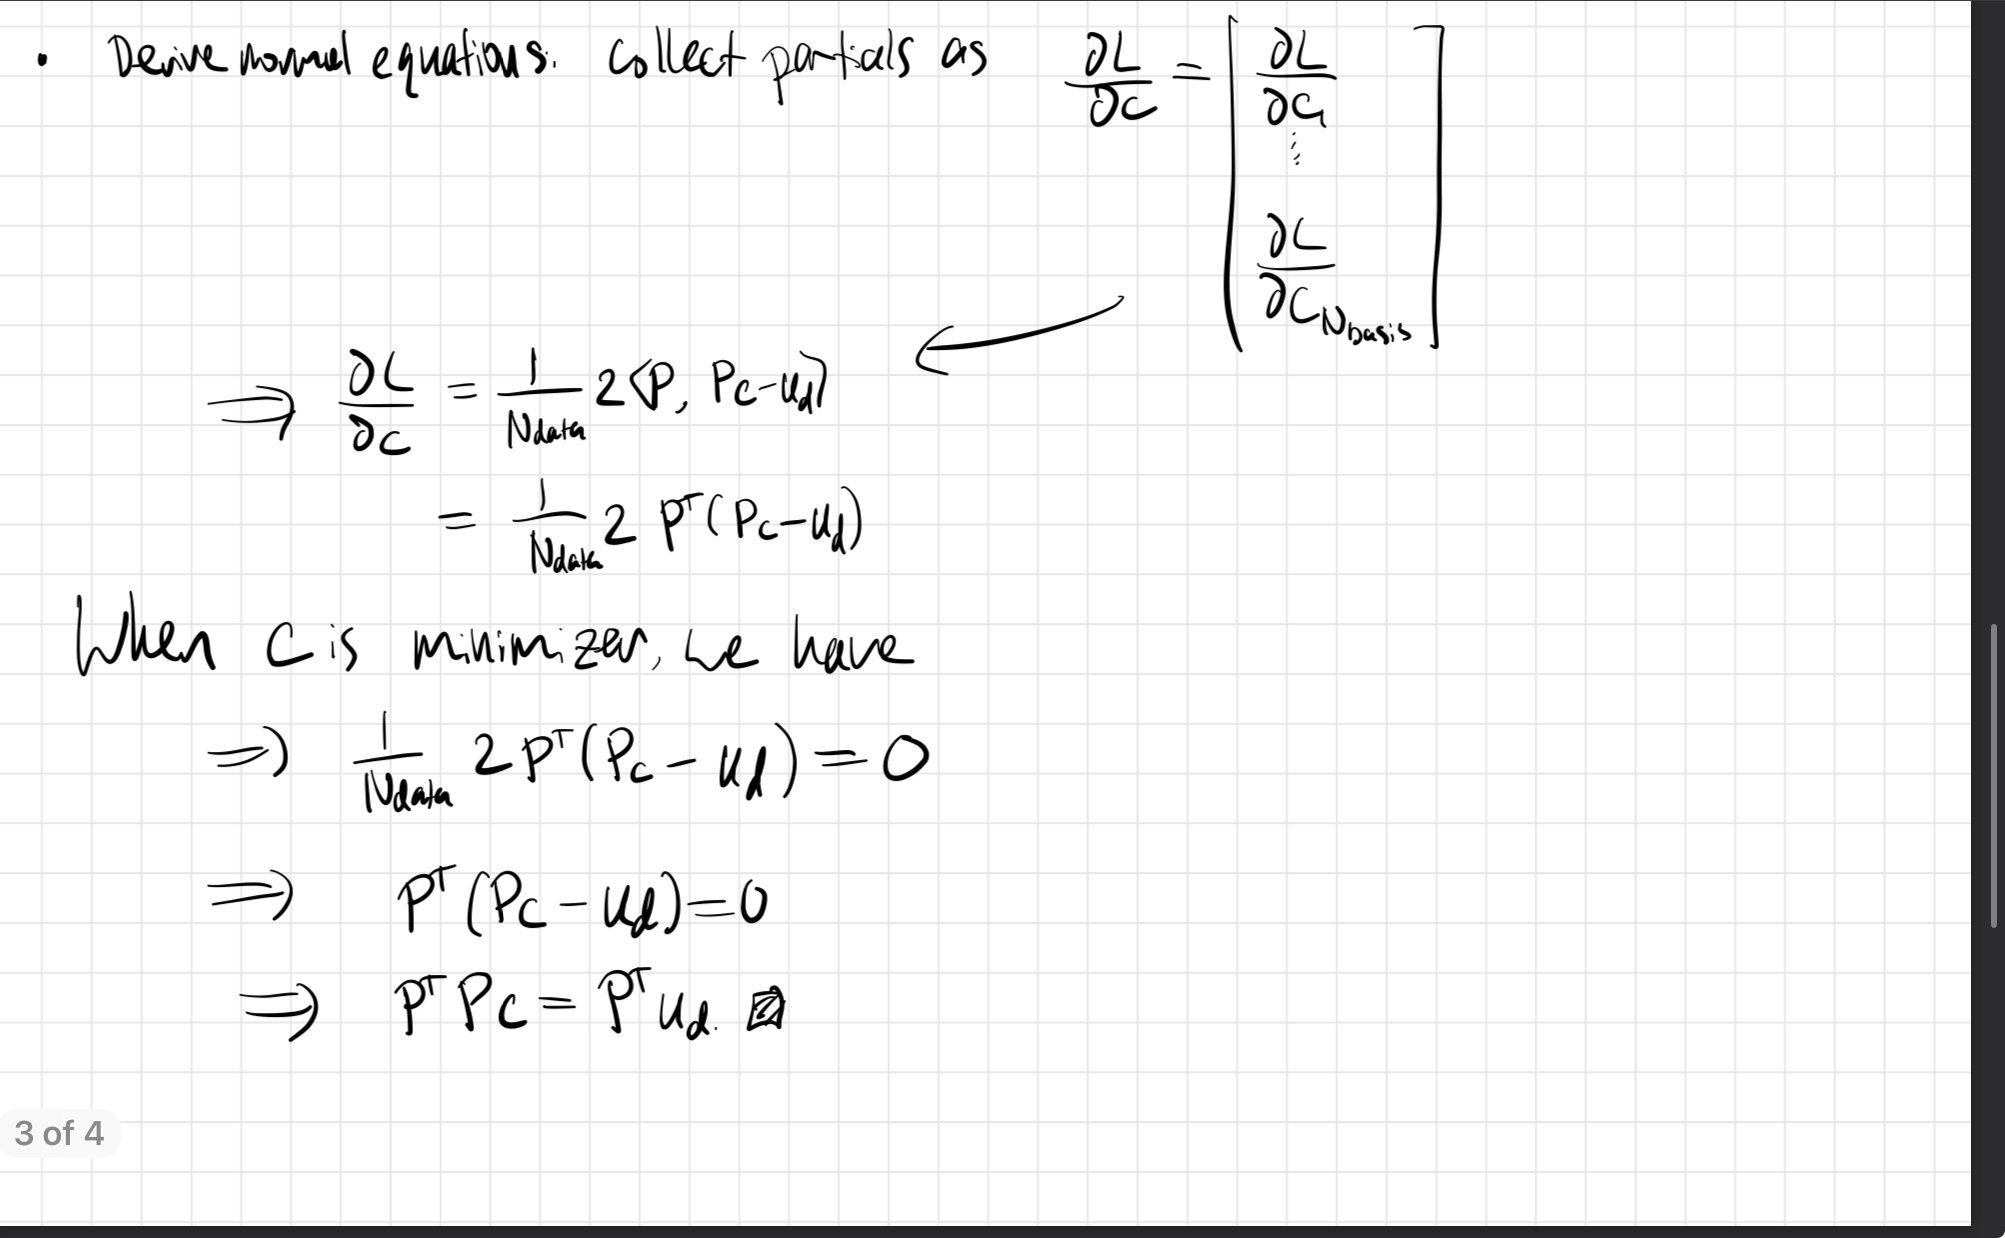

# 2. Multilayer Perceptron with Different Dataset

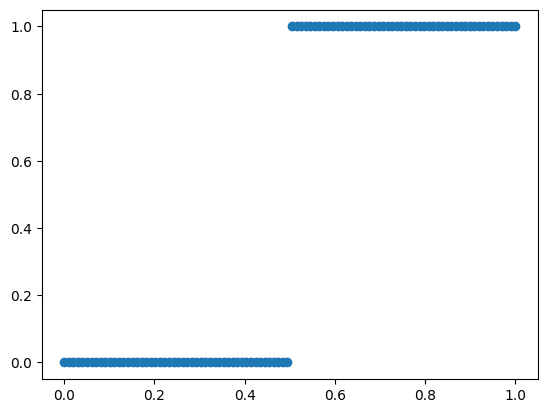

In [10]:
import numpy as np
import matplotlib.pyplot as plt
# Build up original four functions:
def generate_noisylinear_data(N):
    x = np.linspace(0,1,N)
    y = 2*x + 1 + np.random.normal(0,0.2,N)
    return  x,y
def generate_polynomial_data(N):
    x = np.linspace(0,1,N)
    y = x**3 - 2*x**2+x-4.0
    return  x,y
def generate_smoothfunction_data(N):
    x = np.linspace(0,1,N)
    y = np.sin(2.*np.pi*x)
    # modify function here
    return  x,y
def generate_stepfunction_data(N):
    x = np.linspace(0,1,N)
    y = np.float32(x>0.5)
    return  x,y

# Visualize the data
[xdata,ydata] = generate_stepfunction_data(100)
plt.plot(xdata,ydata,'o')
# print(ydata)

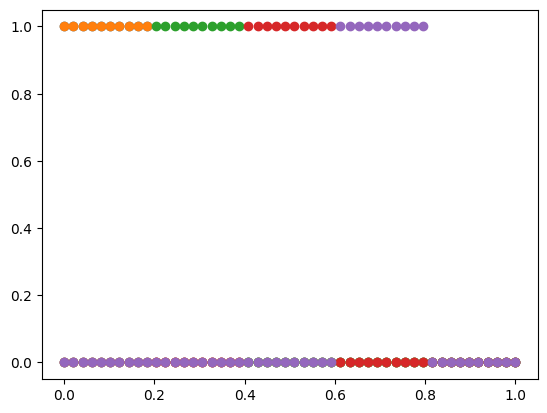

In [11]:
N = 4
M = 50
# Construct N indicator functions defined on M grid points
def generate_indicator_functions(N=4, M=50):
  x = np.linspace(0, 1, M)
  function_pairs = []

  for i in range(N):
    y = np.zeros_like(x)
    for j in range(M):
      y[j] = np.float32(x[j] >= i / (N + 1) and x[j] <= (i + 1) / (N + 1))
    function_pairs.append((x, y))
  return function_pairs

# visualize indicator functions
function_pairs = generate_indicator_functions(N, M)
plt.plot(function_pairs[0][0], function_pairs[0][1], 'o')
for (xdata, ydata) in function_pairs:
  plt.plot(xdata, ydata, 'o')
#print(ydata)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
# build tensor based on indicator functions
data_tensor = torch.stack([torch.stack([torch.tensor(xdata, dtype=torch.float32),
                                        torch.tensor(ydata, dtype=torch.float32)]) for (xdata, ydata) in function_pairs])

print(data_tensor.shape) # Output: torch.Size([4, 2, 50])

torch.Size([4, 2, 50])


In [13]:

# Define the model (in our case, its y = A*x + b)
class BasisDNNLayer(nn.Module):
    def __init__(self,Nbasis):
        super(BasisDNNLayer, self).__init__()
        # Define a simple MLP with two hidden layer
        self.Nneurons = 50
        self.hidden1 = nn.Linear(1, self.Nneurons)  # 1 input feature, N hidden units
        self.hidden2 = nn.Linear(self.Nneurons, self.Nneurons)  # N input feature, N hidden units
        self.hidden3 = nn.Linear(self.Nneurons, self.Nneurons)  # N input feature, N hidden units
        #self.hidden4 = nn.Linear(self.Nneurons, self.Nneurons)  # N input feature, N hidden units
        self.output = nn.Linear(self.Nneurons, Nbasis)  # N hidden units, 1 output feature

    def forward(self, x):
        # We use the ReLU activation function for the hidden layer
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        #x = torch.relu(self.hidden4(x))
        x = self.output(x)
        return x

In [14]:
# Instantiate the custom layer
layer = BasisDNNLayer(N)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(layer.parameters(), lr=0.001)

In [15]:
dataindex = 1
x_data = data_tensor[dataindex,0,:]
y_data = data_tensor[dataindex,1,:]
# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    basis = layer(x_data.unsqueeze(-1)).squeeze(-1)
    A_mat = torch.einsum('da,db->ab',basis,basis)
    b_vec = torch.einsum('da,fd->af',basis,data_tensor[:,1,:])
    c_vec = torch.linalg.solve(A_mat,b_vec)
    y_fit = torch.einsum('da,af->fd', basis, c_vec)
    error = y_fit - data_tensor[:,1,:]
    loss = torch.mean(error**2)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10000], Loss: 0.0882
Epoch [1001/10000], Loss: 0.0099
Epoch [2001/10000], Loss: 0.0062
Epoch [3001/10000], Loss: 0.0011
Epoch [4001/10000], Loss: 0.0005
Epoch [5001/10000], Loss: 0.0000
Epoch [6001/10000], Loss: 0.0000
Epoch [7001/10000], Loss: 0.0005
Epoch [8001/10000], Loss: 0.0004
Epoch [9001/10000], Loss: 0.0000


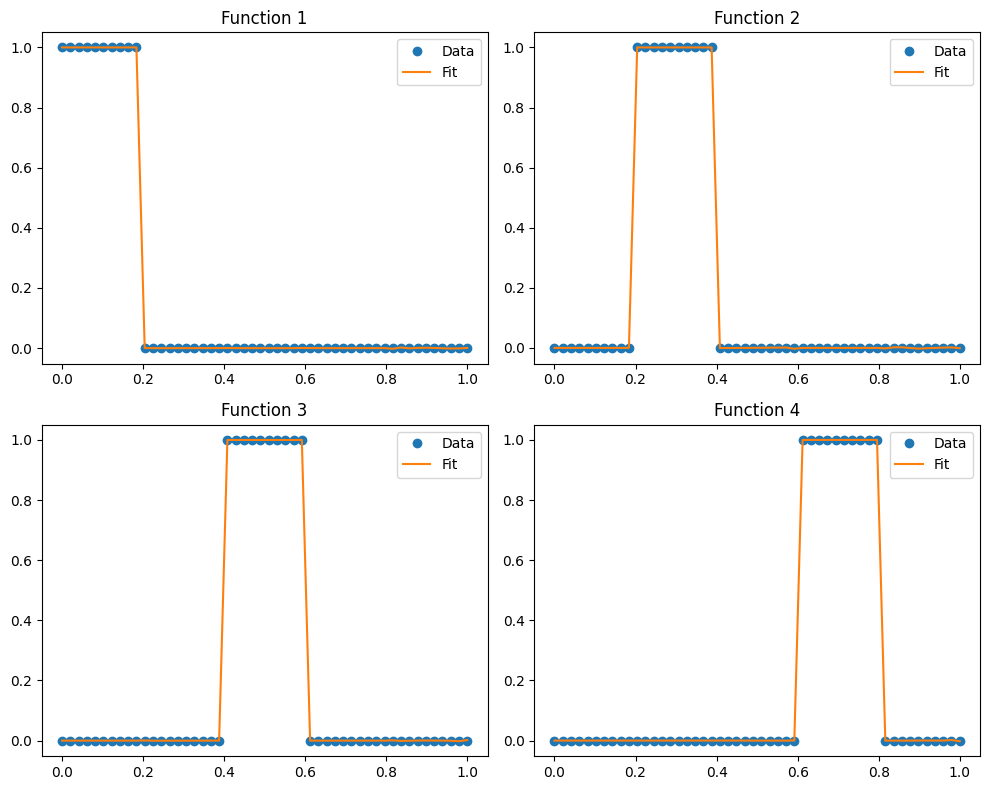

In [16]:
import matplotlib.pyplot as plt

#evaluate the fit function
y_fit = torch.einsum('da,af->fd', basis, c_vec)

# make some plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i in range(N):
    x_data = data_tensor[i, 0, :]
    y_data = data_tensor[i, 1, :]
    fitplot = y_fit[i,:]

    axes[i].plot(x_data.detach().numpy(), y_data.detach().numpy(), 'o', label='Data')
    axes[i].plot(x_data.detach().numpy(), fitplot.detach().numpy(), '-', label='Fit')
    axes[i].set_title(f'Function {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()

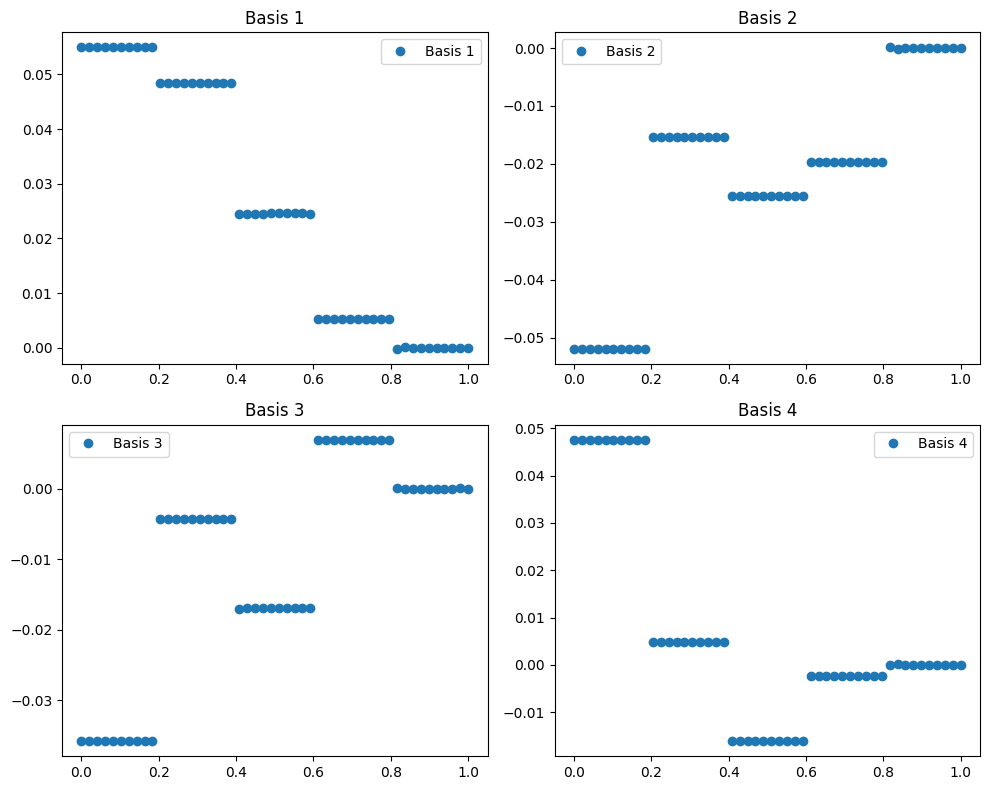

In [26]:
# plot basis
basis.shape
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
for i in range(N):
  basis_i = basis[:, i]
  axes[i].plot(x_data.detach().numpy(), basis_i.detach().numpy(), 'o', label = f'Basis {i+1}')
  axes[i].set_title(f'Basis {i+1}')
  axes[i].legend()


plt.tight_layout()
plt.show()

**Comments:** Each of the input functions in this case was a step function, and that step structure was fully captured by the learned basis as shown in the second to last plot. This allows for the great fit we observe. This fit is corroborated by the least squares error shown in the last plot. On the other hand, the lecture notes handled two smooth functions and one step function that was piece-wise continuous. Hence the fit for the noisy linear function does not capture the overall structure of the data that we may have wanted.